In [ ]:
#access gdrive folder: 20_440Project_JS_TF_AMB must be in MyDrive
from google.colab import drive

drive.mount("/content/drive")
%cd /content/drive/My Drive/20_440Project_JS_TF_AMB

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/11ayn8NvvhQcP_j3xRQ6p0HIXj3agZbuK/20_440Project_JS_TF_AMB


# Install and load dependencies

In [ ]:
%pip install pydeseq2
%pip install scanpy
%pip install sanbomics
%pip install bioinfokit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 494.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.1/122.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.0 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=99923f61fe3b5d0859faabbb2264ab33f452567d88ea6c3776ec2af0a3ea7e6f
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 1.4 MB/s eta 0:00:00
  Preparing metadat

In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from functools import reduce
from sanbomics.plots import volcano
from bioinfokit import analys,visuz


import pandas as pd
import seaborn as sns
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# Run DeSeq2

In [ ]:
merged = pd.read_csv('dataset/MetaData/MetaData_badGoodDiffs_TF6.tsv', delimiter='\t')
merged.set_index(merged.columns[0], inplace=True)
merged.sort_index(inplace=True)
merged = merged.astype(int)

In [ ]:
labels = ['Poor Diff'] * 3 + ['Functional Diff'] * 3

metadata = pd.DataFrame(zip(merged.index, labels),
                        columns = ['Sample', 'Condition'])
metadata = metadata.set_index('Sample')

In [ ]:
dds = DeseqDataSet(counts=merged,
            metadata=metadata,
            design_factors="Condition",
            ref_level = ["Condition", "Functional Diff"])

In [ ]:
dds.deseq2()

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 9.05 seconds.

Fitting dispersion trend curve...
... done in 0.59 seconds.

Fitting MAP dispersions...
... done in 16.01 seconds.

Fitting LFCs...
... done in 9.04 seconds.

Replacing 0 outlier genes.



In [ ]:
stat_res = DeseqStats(dds, contrast = ('Condition','Functional Diff','Poor Diff'))

stat_res.summary()
res = stat_res.results_df

Running Wald tests...
... done in 4.86 seconds.



Log2 fold change & Wald test p-value: Condition Functional Diff vs Poor Diff
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG      0.000000             NaN       NaN       NaN       NaN       NaN
A1CF      0.000000             NaN       NaN       NaN       NaN       NaN
A2M       2.288279        4.616992  2.030907  2.273364  0.023004       NaN
A2ML1     0.000000             NaN       NaN       NaN       NaN       NaN
A3GALT2   0.000000             NaN       NaN       NaN       NaN       NaN
...            ...             ...       ...       ...       ...       ...
ZXDC      4.628338        1.030324  0.666229  1.546501  0.121984  0.283288
ZYG11A    0.000000             NaN       NaN       NaN       NaN       NaN
ZYG11B    7.923587        1.233156  0.527137  2.339349  0.019317  0.068627
ZYX      66.483619       -0.522564  0.205436 -2.543681  0.010969  0.044568
ZZEF1     3.482582        0.367097  0.732099  0.501431  0.616068  0.791360

[19936 rows x 6 column

# Differentially Expressed Genes

In [ ]:
!pip install gseapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.6 MB/s eta 0:00:00


In [ ]:
import gseapy as gp
from gseapy.plot import gseaplot

In [ ]:
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,0.000000,NaN,NaN,NaN,NaN,NaN
A1CF,0.000000,NaN,NaN,NaN,NaN,NaN
A2M,2.288279,4.616992,2.030907,2.273364,0.023004,NaN
A2ML1,0.000000,NaN,NaN,NaN,NaN,NaN
A3GALT2,0.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
ZXDC,4.628338,1.030324,0.666229,1.546501,0.121984,0.283288
ZYG11A,0.000000,NaN,NaN,NaN,NaN,NaN
ZYG11B,7.923587,1.233156,0.527137,2.339349,0.019317,0.068627
ZYX,66.483619,-0.522564,0.205436,-2.543681,0.010969,0.044568


In [ ]:
#Filter based on p-value
ranking = res[res['pvalue'] <= 0.05]

#Sort based on abs log2 fold change
ranking = ranking[['log2FoldChange']].dropna()
ranking['abs_l2FC'] = ranking['log2FoldChange'].abs()
ranking.sort_values(by='abs_l2FC', ascending=False, inplace=True)
ranking = ranking[ranking['abs_l2FC'] > 1]

ranking.drop(columns=['abs_l2FC'], inplace=True)


ranking

,log2FoldChange
MYH7,11.651775
SHISA3,-11.372107
CKM,10.765121
HSPB3,10.467528
PLAT,-9.600790
...,...
ACADM,1.004349
GBA2,1.004099
FGFRL1,-1.002918
RRAGA,1.002801


In [ ]:
pre_res = gp.prerank(rnk=ranking, # or rnk = rnk,
                     gene_sets='GO_Biological_Process_2021',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

2024-04-01 22:50:59,968 [WARNING] Duplicated values found in preranked stats: 7.59% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-04-01 22:50:59,971 [INFO] Parsing data files for GSEA.............................
2024-04-01 22:51:00,703 [INFO] Downloading and generating Enrichr library gene sets......
2024-04-01 22:51:11,891 [INFO] 4095 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-04-01 22:51:11,905 [INFO] 1941 gene_sets used for further statistical testing.....
2024-04-01 22:51:11,910 [INFO] Start to run GSEA...Might take a while..................
2024-04-01 22:52:10,515 [INFO] Congratulations. GSEApy runs successfully................



In [ ]:
out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes'],
               pre_res.results[term]['gene %'],
               pre_res.results[term]['lead_genes'],])

out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes','gene %','lead_genes']).sort_values('nes').reset_index(drop = True)

out_df['abs_nes'] = abs(out_df['nes'])  # Create a new column with absolute NES values
out_df = out_df.sort_values('abs_nes', ascending=False).reset_index(drop=True)

out_df.drop('abs_nes', axis=1, inplace=True)

# Save the sorted DataFrame to a TSV file
out_df.to_csv('GSEA/good_vs_bad_diff.tsv', sep='\t', index=False)

out_df

,Term,fdr,es,nes,gene %,lead_genes
0,muscle contraction (GO:0006936),0.000000,0.681916,3.110936,8.81%,MYH7;LMOD2;MYL2;CRYAB;TCAP;MYL3;MYOM1;MYBPC3;K...
1,heart contraction (GO:0060047),0.000000,0.837250,3.069800,8.08%,MYH7;MYL2;CSRP3;TCAP;MYL3;MYBPC3;SCN5A;TNNC1;T...
2,striated muscle contraction (GO:0006941),0.000000,0.786714,3.015865,8.24%,MYH7;CSRP3;TCAP;MYL3;MYBPC3;KLHL41;SCN5A;TNNC1...
3,cardiac muscle contraction (GO:0060048),0.000000,0.790702,2.894806,8.08%,MYH7;CSRP3;TCAP;MYL3;MYBPC3;SCN5A;TNNC1;TNNI3;...
4,actin-myosin filament sliding (GO:0033275),0.000000,0.737147,2.774734,8.81%,MYH7;MYL2;TCAP;MYL3;MYBPC3;TNNC1;ACTN2;TNNI3;T...
...,...,...,...,...,...,...
1936,protein K48-linked ubiquitination (GO:0070936),0.997128,0.144615,0.431123,85.59%,KLHL3;RNF115;UBE2B;UBE2E2;UBE2Q2;UBE2E1;UBE2C;...
1937,organic substance transport (GO:0071702),0.997062,0.116770,0.418006,9.54%,ABCA3;RILP
1938,establishment of protein localization to extra...,0.998903,-0.176086,-0.417319,22.95%,ARL4D;OLFM2
1939,activation of GTPase activity (GO:0090630),1.000000,-0.126587,-0.370291,87.43%,ARHGAP22;TIAM1;SIPA1;GMIP;TBC1D16;RABGAP1;TBC1...


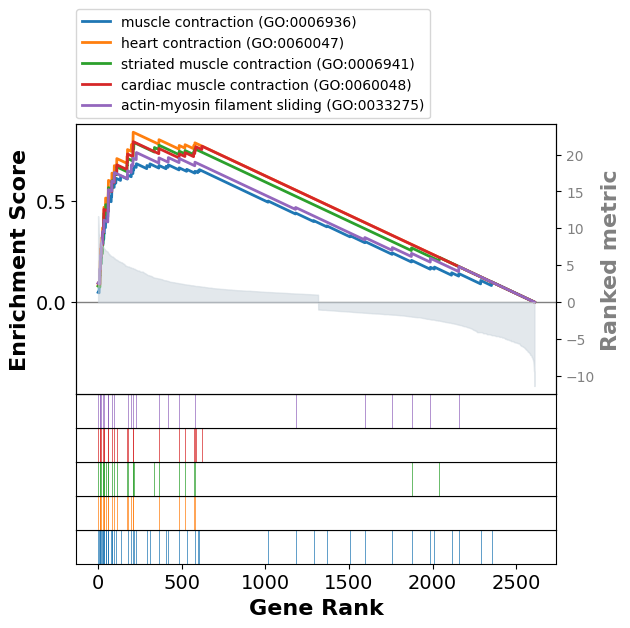

In [ ]:
terms = out_df['Term']

axs = pre_res.plot(terms=terms[0:5],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

# Heat Map

In [ ]:
import sys
sys.setrecursionlimit(10000)  # Set a higher recursion limit (adjust the value as needed)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


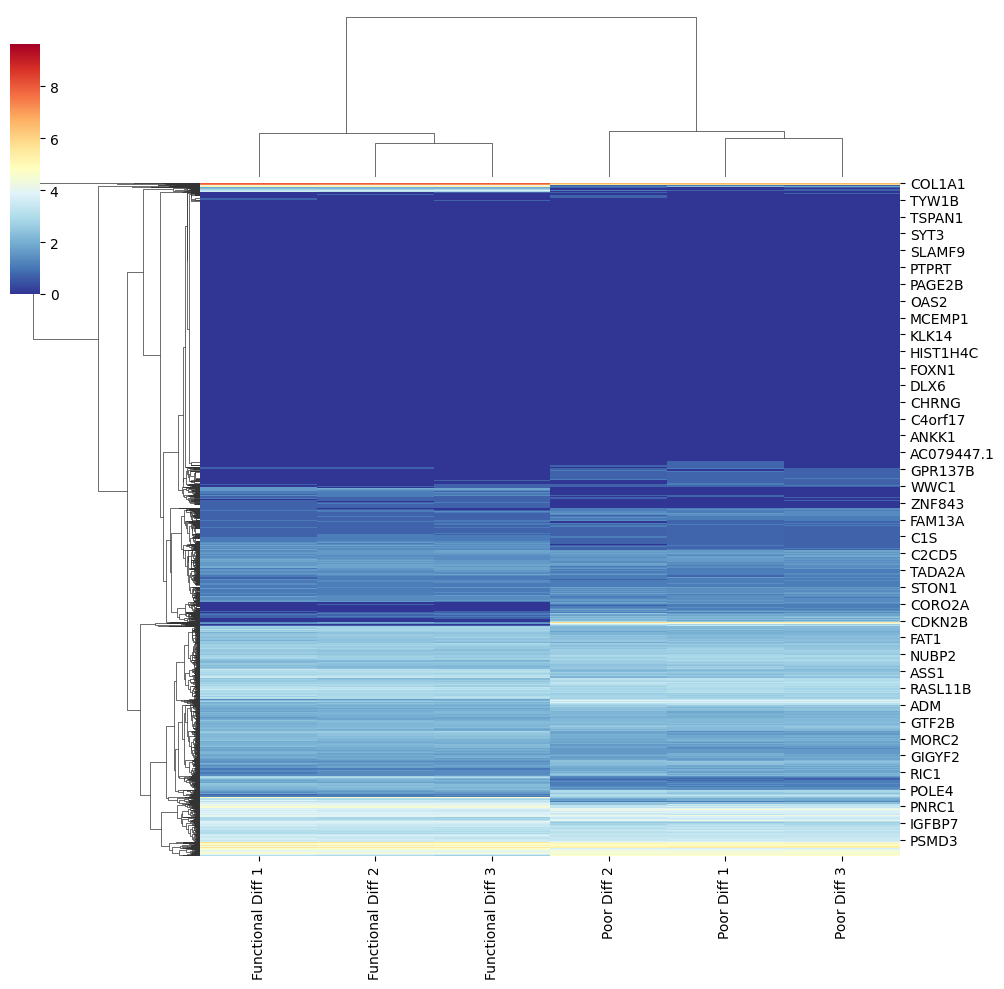

In [ ]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds_res = dds[:, res.index]

pattern_repetitions = {'Poor Diff': 3, 'Functional Diff': 3}
col_labels = [f'{pattern} {i}' for pattern, repetitions in pattern_repetitions.items() for i in range(1, repetitions + 1)]

grapher_res = pd.DataFrame(dds_res.layers['log1p'].T,
                       index=dds_res.var_names, columns=col_labels)

sns.clustermap(grapher_res, cmap='RdYlBu_r',cbar_pos=(0, 0.7, .03, .25))

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


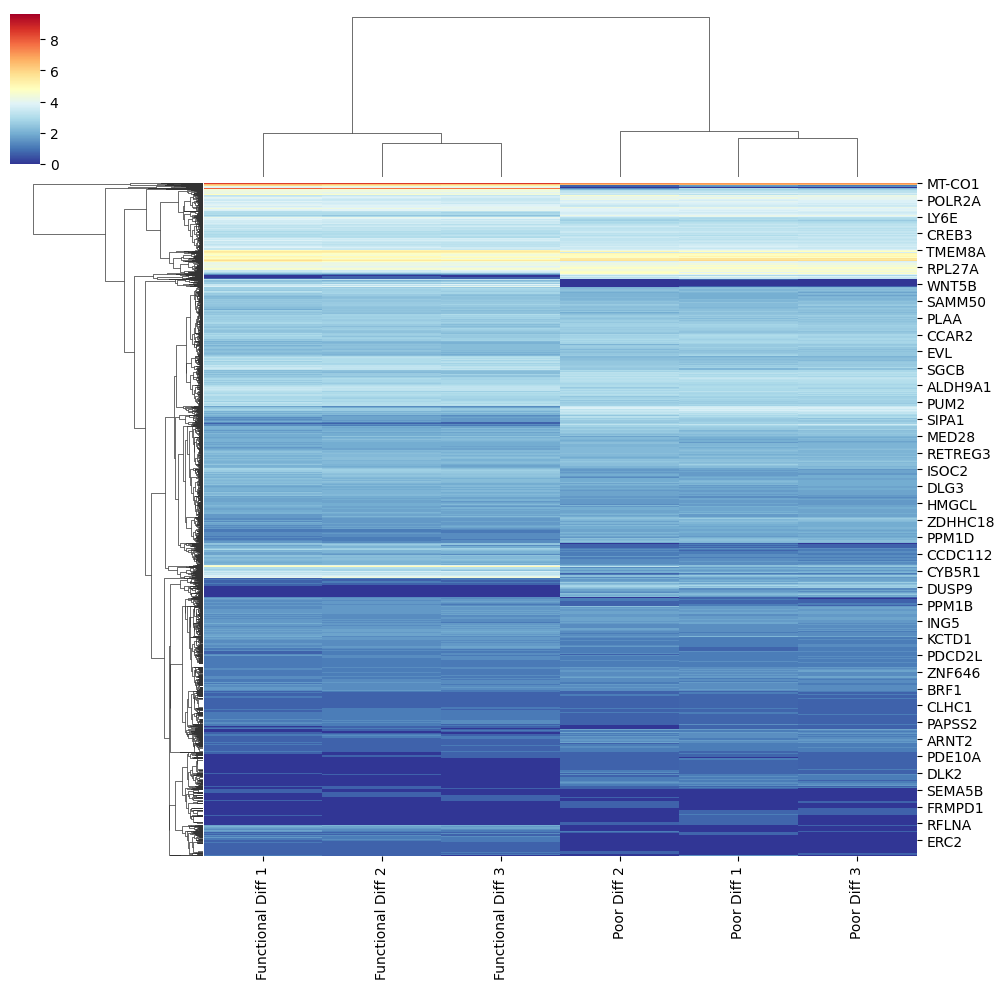

In [ ]:
grapher_res_filtered = grapher_res.loc[~(grapher_res == 0).all(axis=1)]

sns.clustermap(grapher_res_filtered, cmap='RdYlBu_r',cbar_pos=(0, 0.83, .03, .15))

In [ ]:
cardiac_genes = pd.read_csv('cardiac_genes.csv', delimiter='\t')

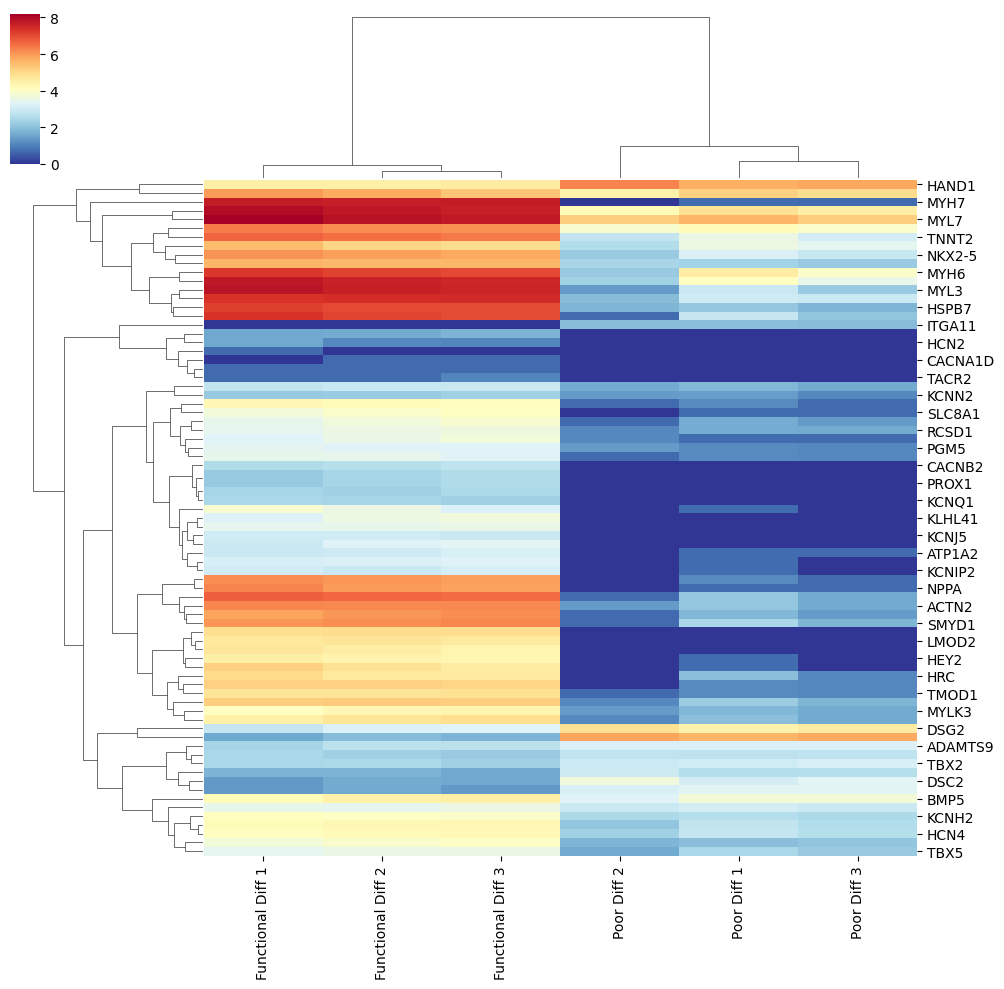

In [ ]:
subset_grapher_res = grapher_res.loc[cardiac_genes['Gene']]
subset_grapher_res = subset_grapher_res.loc[~(grapher_res == 0).all(axis=1)]


sns.clustermap(subset_grapher_res, cmap='RdYlBu_r',cbar_pos=(0, 0.83, .03, .15))

# KEGG Pathway Analysis

In [ ]:
%pip install pykegg
%pip install requests_cache

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
import pykegg
import requests_cache
import numpy as np
from PIL import Image
from Bio.KEGG import REST

## Cache all the downloaded
requests_cache.install_cache('pykegg_cache')

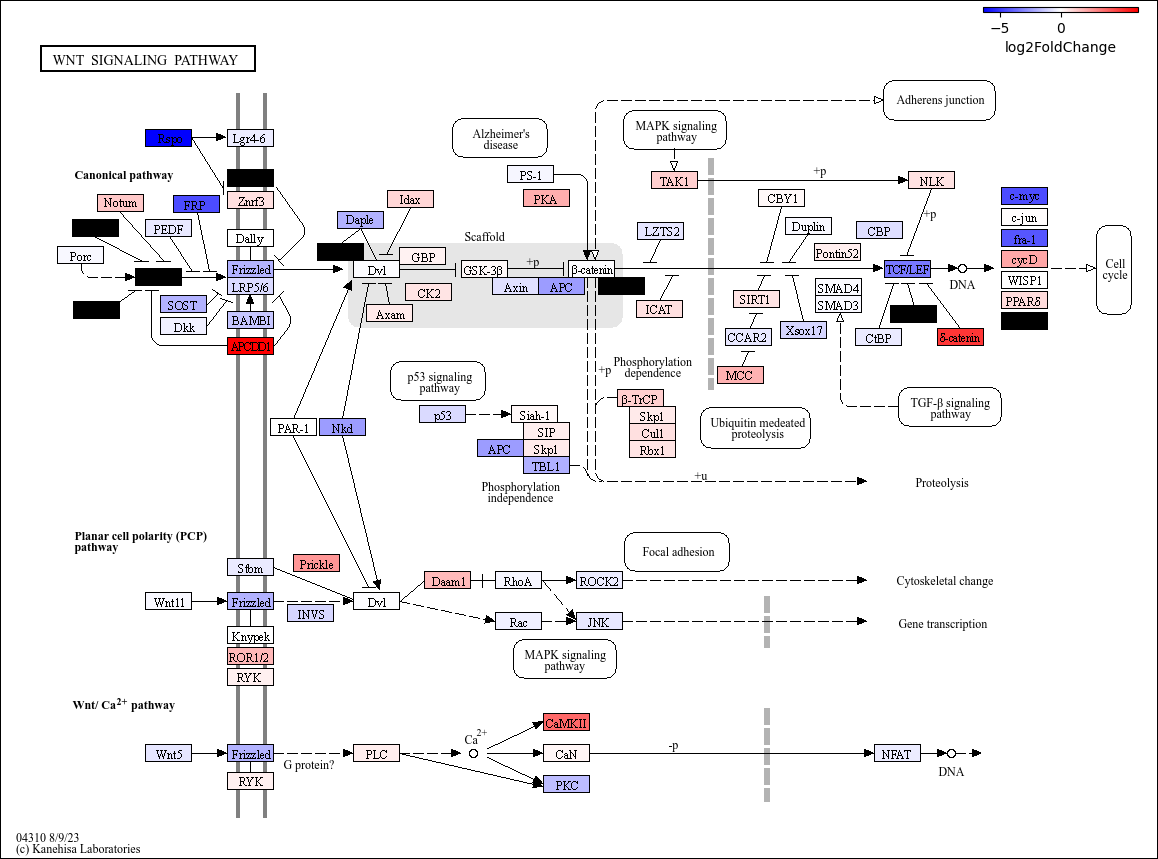

In [ ]:
pykegg.deseq2_raw_map(res, pid="hsa04310", legend_width=2)